In [2]:
import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Tensorflow: ", tensorflow.__version__)



Python:  3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
pandas:  2.0.0
numpy:  1.22.2
seaborn:  0.11.2
matplotlib:  3.7.1
sklearn:  1.2.2
Tensorflow:  2.7.0


In [ ]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [4]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format



In [5]:


from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

#cnn autoencoder
logfilename = "cnnautoencoder2"

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

autoencoder.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584   

In [6]:
autoencoder.compile(optimizer=RMSprop(), 
                    loss='mean_squared_error',
                    metrics=['mae', 'accuracy'])

In [7]:
batch_size = 32
epochs = 20

history = autoencoder.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    callbacks=[TensorBoard(log_dir='./logs/{0}'.format(logfilename))])

Epoch 1/20
1875/1875 [==============================] - 30s 10ms/step - loss: 0.0367 - mae: 0.0873 - accuracy: 0.7978 - val_loss: 0.0253 - val_mae: 0.0628 - val_accuracy: 0.8069
Epoch 2/20
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0219 - mae: 0.0579 - accuracy: 0.8071 - val_loss: 0.0208 - val_mae: 0.0540 - val_accuracy: 0.8107
Epoch 3/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0183 - mae: 0.0507 - accuracy: 0.8096 - val_loss: 0.0164 - val_mae: 0.0473 - val_accuracy: 0.8080
Epoch 4/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0166 - mae: 0.0473 - accuracy: 0.8105 - val_loss: 0.0157 - val_mae: 0.0454 - val_accuracy: 0.8115
Epoch 5/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0155 - mae: 0.0452 - accuracy: 0.8111 - val_loss: 0.0154 - val_mae: 0.0449 - val_accuracy: 0.8084
Epoch 6/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0148 - mae: 0.0438 - accuracy: 0.81

In [11]:
score = autoencoder.evaluate(x_test, x_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 2s 5ms/step - loss: 0.0110 - mae: 0.0353 - accuracy: 0.8126
Test loss: 0.011009062640368938
Test accuracy: 0.035254064947366714


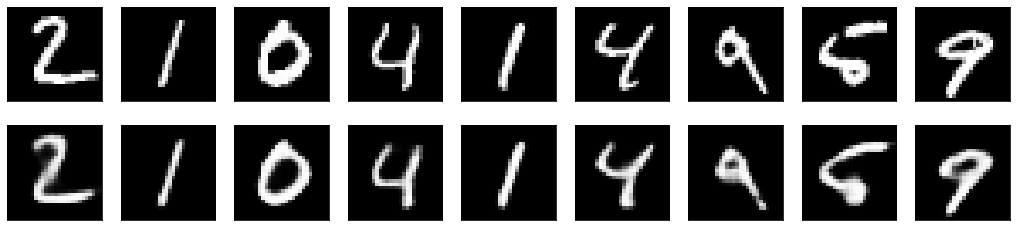

In [9]:


decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()



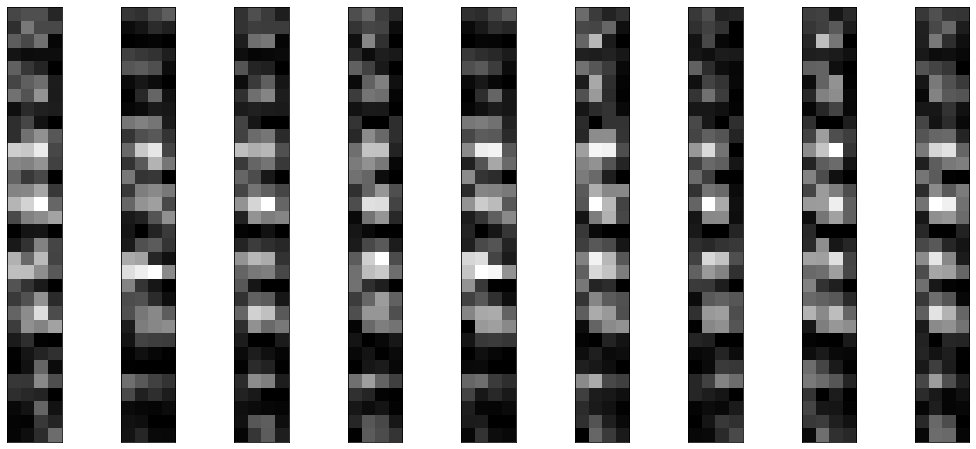

In [10]:


encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)
n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

